In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, Input
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MinMaxScaler
import keras_tuner as kt

2025-02-20 18:17:51.590149: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-20 18:17:51.597970: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740071871.606473  313138 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740071871.609066  313138 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-20 18:17:51.619135: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
TIME_STEPS = 4  # The model will look at 4 consecutive timestamps at once
def create_sequences(X, y, time_steps):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i : i + time_steps])  # Collect time_steps observations
        y_seq.append(y[i + time_steps])  # Predict the next value (shifted target)
    return np.array(X_seq), np.array(y_seq)

In [3]:
df=pd.read_csv("datasets/sensor.csv")
print(df.isnull().sum())

Unnamed: 0             0
timestamp              0
sensor_00          10208
sensor_01            369
sensor_02             19
sensor_03             19
sensor_04             19
sensor_05             19
sensor_06           4798
sensor_07           5451
sensor_08           5107
sensor_09           4595
sensor_10             19
sensor_11             19
sensor_12             19
sensor_13             19
sensor_14             21
sensor_15         220320
sensor_16             31
sensor_17             46
sensor_18             46
sensor_19             16
sensor_20             16
sensor_21             16
sensor_22             41
sensor_23             16
sensor_24             16
sensor_25             36
sensor_26             20
sensor_27             16
sensor_28             16
sensor_29             72
sensor_30            261
sensor_31             16
sensor_32             68
sensor_33             16
sensor_34             16
sensor_35             16
sensor_36             16
sensor_37             16


In [4]:
sensors_to_drop = ['Unnamed: 0', 'timestamp','sensor_15', 'sensor_50']
df = df.drop(columns=sensors_to_drop)

sensor_cols = df.columns[df.isnull().any()].tolist()
df[sensor_cols] = df[sensor_cols].interpolate(method='linear')

# If any remaining NaNs, use forward/backward fill
df[sensor_cols] = df[sensor_cols].fillna(method='ffill')
df[sensor_cols] = df[sensor_cols].fillna(method='bfill')
# Verify no missing values remain
broken_positions = df.index[df["machine_status"] == "BROKEN"].tolist()

# Assign "BROKEN" to 59 previous points
for pos in broken_positions:
    start = max(0, pos - 20)  # Ensure we don't go below index 0
    df.loc[start:pos, "machine_status"] = "BROKEN"

/tmp/ipykernel_313138/4147132387.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[sensor_cols] = df[sensor_cols].fillna(method='ffill')
/tmp/ipykernel_313138/4147132387.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[sensor_cols] = df[sensor_cols].fillna(method='bfill')


In [5]:
y=df["machine_status"]
X=df.drop(columns=['machine_status'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)
scaler=MinMaxScaler()
scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

X_train_seq, y_train_seq = create_sequences(X_train, y_train, TIME_STEPS)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, TIME_STEPS)

In [6]:
print(np.shape(df))
unique, counts = np.unique(y, return_counts=True)

# Display results
category_counts = dict(zip(unique, counts))
print(category_counts)


(220320, 51)
{'BROKEN': 147, 'NORMAL': 205696, 'RECOVERING': 14477}


In [7]:
print(y.head())

0    NORMAL
1    NORMAL
2    NORMAL
3    NORMAL
4    NORMAL
Name: machine_status, dtype: object


In [8]:
label_encoder = LabelEncoder()
y_train_seq = label_encoder.fit_transform(y_train_seq)
y_test_seq = label_encoder.transform(y_test_seq)

# Convert to one-hot encoding
num_classes = len(np.unique(y_train_seq))
print(num_classes)
print(np.unique(y_test))
categories=np.unique(y_test)
y_train_seq = to_categorical(y_train_seq, num_classes)
y_test_seq = to_categorical(y_test_seq, num_classes)

3
['BROKEN' 'NORMAL' 'RECOVERING']


In [9]:
print(np.unique(y_train_seq))
print(np.argmax(y_train_seq, axis=1))
y_train_classes = np.argmax(y_train_seq, axis=1)

# Compute class weights
class_labels = np.unique(y_train_classes)
class_weights = compute_class_weight(class_weight="balanced", classes=class_labels, y=y_train_classes)

# Convert to a dictionary for Keras
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

[0. 1.]
[1 1 1 ... 1 1 1]


In [10]:
from sklearn.metrics import accuracy_score
class_accs=0
class PerClassAccuracyCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_data, class_names=None):
        """
        Callback to compute per-class accuracy after each epoch.
        
        val_data: (X_val, y_val) validation dataset
        class_names: List of class names for logging
        """
        super().__init__()
        self.X_val, self.y_val = val_data
        self.class_names = class_names# if class_names else np.unique(self.y_val)

    def on_epoch_end(self, epoch, logs=None):
        # Get model predictions
        y_pred = self.model.predict(self.X_val, verbose=0)
        y_pred_classes = np.argmax(y_pred, axis=1)  # Convert softmax to class labels
        y_true_classes = np.argmax(self.y_val, axis=1)  # True class labels

        # Compute per-class accuracy
        class_accuracies = {}
        global class_accs
        class_accs=0
        accss=[]
        for class_idx in np.unique(y_true_classes):
            mask = (y_true_classes == class_idx)
            acc = accuracy_score(y_true_classes[mask], y_pred_classes[mask])
            class_name = self.class_names[class_idx] if isinstance(self.class_names, list) else class_idx
            class_accuracies[class_name] = acc
            accss.append(acc)
            class_accs+=acc
        #class_accs=class_accs/len(categories)
        class_accs=min(accss)
        # Log per-class accuracy
        #print(f"\nEpoch {epoch+1} Per-Class Accuracy:")
        #for class_name, acc in class_accuracies.items():
        #    print(f"  - {class_name}: {acc:.4f}")

        logs = logs or {}
        logs.update(class_accuracies)


In [11]:
import tensorflow.keras.backend as K
def balanced_focal_loss(alpha=None, gamma=2.0):
    """
    Balanced focal loss that ensures equal per-category contribution.
    """
    def loss(y_true, y_pred):
        y_true = K.cast(y_true, K.floatx())
        ce_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)

        # Compute per-class loss
        num_classes = K.shape(y_true)[-1]
        class_losses = []

        for class_idx in range(len(categories)):
            class_mask = y_true[:, class_idx]
            focal_weight = K.pow(1 - y_pred[:, class_idx], gamma)  # Focal scaling
            masked_loss = ce_loss * class_mask * focal_weight  # Apply mask & focal scaling

            avg_loss = K.sum(masked_loss) / (K.sum(class_mask) + K.epsilon())
            class_losses.append(avg_loss)

        # Average per-class losses
        final_loss = K.mean(K.stack(class_losses))
        return final_loss

    return loss

In [12]:
def balanced_loss(y_true, y_pred):
    """
    Custom loss function that ensures equal contribution from all categories.
    - Computes categorical cross-entropy per category.
    - Averages losses across all classes.
    """
    # Convert labels to float
    y_true = K.cast(y_true, K.floatx())

    # Compute standard categorical cross-entropy loss
    ce_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)

    # Compute loss per class
    num_classes = K.shape(y_true)[-1]  # Number of classes
    class_losses = []

    for class_idx in range(len(categories)):
        # Mask for samples belonging to the current class
        class_mask = y_true[:, class_idx]  # Extract true labels for this class
        masked_loss = ce_loss * class_mask  # Apply the mask

        # Compute mean loss for this class (avoid division by zero)
        avg_loss = K.sum(masked_loss) / (K.sum(class_mask) + K.epsilon())
        class_losses.append(avg_loss)

    # Average across all classes (equal contribution)
    final_loss = K.mean(K.stack(class_losses))
    
    return final_loss

In [13]:
class MyHyperband(kt.Hyperband):
    """
    A custom Hyperband tuner that, after each trial, builds the model
    from the trial’s hyperparameters and logs its parameter count.
    
    (This is one approach to letting the tuner “see” both validation accuracy
     and model size so that it can search for an architecture that is both
     accurate and compact.)
    """
    def run_trial(self, trial, *args, **kwargs):
        # Run the standard training for this trial.
        logs = {}
        per_class_callback = PerClassAccuracyCallback((X_test_seq, y_test_seq), categories)
        #if 'callbacks' in kwargs:
        #    kwargs['callbacks'].append(per_class_callback)
        #else:
        #    kwargs['callbacks'] = [per_class_callback]
        super(MyHyperband, self).run_trial(
            trial, *args,
            callbacks=[tf.keras.callbacks.LambdaCallback(
                on_epoch_end=lambda epoch, log: logs.update(log)
            )],
            **kwargs
        )
        val_loss = logs["val_loss"]
        avg=0
        global class_accs
        avg=class_accs
        # Ensure val_accuracy is present
        #if "val_accuracy" in logs:
        #    val_accuracy = logs["val_accuracy"],
        
       # else:
       #     val_accuracy = 0.0  # Default to zero if not found (prevents crash)

        # Build the model from the trial’s hyperparameters (we don’t need to train it here)
        model = self.hypermodel.build(trial.hyperparameters)
        param_count = model.count_params()
        
        # Update the trial with the parameter count metric.
        # (We assume that the tuner was set up to track a metric named "param_count".)
        #goodness=val_loss#-0.00001*param_count
        goodness=val_loss
        self.oracle.update_trial(
            trial.trial_id, {
                "goodness": goodness
            }
        )
        return {
            "goodness": goodness
        }

In [14]:
def build_model(hp):
    num_features = X_train.shape[1]
    inputs = Input(shape=(TIME_STEPS, num_features))
    # Initial convolution layer
    x = layers.Conv1D(64, kernel_size=3, padding="same", activation="relu")(inputs)
    num_blocks = hp.Int("num_blocks", min_value=1, max_value=5, step=1, default=3)
    for i in range(num_blocks):
        filters = hp.Int(f"filters_{i}", min_value=32, max_value=256, step=32, default=64)
        shortcut = x  # save input for the skip connection      
        # First convolution in block
        y = layers.Conv1D(filters, kernel_size=3, padding="same", activation="relu")(x)
        y = layers.BatchNormalization()(y)
        filter2=filters
        # Second convolution in block (no activation until after adding the shortcut)
        y = layers.Conv1D(filter2, kernel_size=3, padding="same")(y)
        y = layers.BatchNormalization()(y)

        # If the number of channels does not match, adjust the shortcut
        if shortcut.shape[-1] != filter2:
            shortcut = layers.Conv1D(filter2, kernel_size=1, padding="same")(shortcut)
        # Add the shortcut (residual connection)
        x = layers.Add()([shortcut, y])
        x = layers.Activation("relu")(x)

    # Global pooling and output classification layer
    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    # Compile the model
    model = models.Model(inputs, outputs)
    #optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # Set LR here
    model.compile(optimizer=tf.keras.optimizers.Adam(
            hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])), 
                loss=balanced_loss,
                metrics=['accuracy']
                )
    return model


In [15]:
tuner = MyHyperband(
    build_model,
    objective=kt.Objective("goodness", direction="min"),
    max_epochs=10,
    factor=3,
    directory="my_dir",
    project_name="resnet_tuner"
)

tuner.search(X_train_seq, y_train_seq, epochs=10, validation_data=(X_test_seq, y_test_seq), class_weight=class_weight_dict)

# Retrieve the best hyperparameters and build the best model
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hp)

# Show the model summary (including parameter count)
best_model.summary()
#history = model.fit(X_train_seq, y_train_seq, epochs=10, batch_size=256, 
#                validation_data=(X_test_seq, y_test_seq),
#                class_weight=class_weight_dict)




Trial 30 Complete [00h 00m 58s]
goodness: 0.3394109606742859

Best goodness So Far: 0.018090547993779182
Total elapsed time: 00h 18m 36s


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 4, 50)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 4, 64)     │      9,664 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 4, 192)    │     37,056 │ conv1d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 192)    │        768 │ conv1d_9[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 4, 192)    │    110,784 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 4, 192)    │     12,480 │ conv1d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 192)    │        768 │ conv1d_10[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 4, 192)    │          0 │ conv1d_11[0][0],  │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 4, 192)    │          0 │ add_2[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 4, 160)    │     92,320 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 160)    │        640 │ conv1d_12[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 4, 160)    │     76,960 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 4, 160)    │     30,880 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 160)    │        640 │ conv1d_13[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 4, 160)    │          0 │ conv1d_14[0][0],  │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 4, 160)    │          0 │ add_3[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 4, 96)     │     46,176 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 96)     │        384 │ conv1d_15[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 4, 96)     │     27,744 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 4, 96)     │     15,456 │ activation_3[0][

 Total params: 662,787 (2.53 MB)

 Trainable params: 659,971 (2.52 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [16]:
#history = best_model.fit(X_train_seq, y_train_seq, epochs=1, validation_data=(X_test_seq, y_test_seq))

In [17]:
# Evaluate the model
loss, metric = best_model.evaluate(X_test_seq, y_test_seq)
print(f"Test Loss: {loss:.4f}, Test {'Accuracy' if 'num_classes' in locals() else 'MAE'}: {metric:.4f}")

3443/3443 ━━━━━━━━━━━━━━━━━━━━ 4s 953us/step - accuracy: 7.4985e-04 - loss: 0.3670
Test Loss: 0.3668, Test Accuracy: 0.0006


3443/3443 ━━━━━━━━━━━━━━━━━━━━ 3s 812us/step
[1 1 1 ... 1 1 1]
[0 0 0 ... 0 0 0]


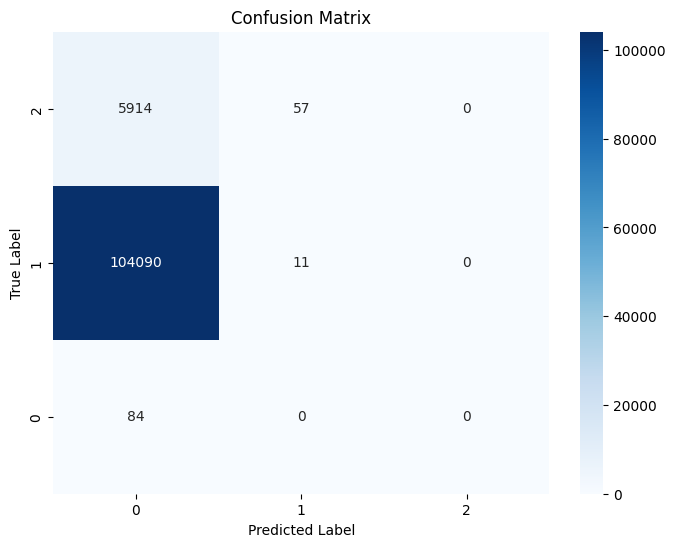

In [18]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
y_pred=best_model.predict(X_train_seq)
y_hat = np.argmax(y_pred, axis=1)  # Get the highest probability class index
y_true = np.argmax(y_train_seq, axis=1)  # Ensure y_true is also class indices
print(y_true)
print(y_hat)
# Compute confusion matrix
# Convert softmax probabilities to class predictions

cm = confusion_matrix(y_true, y_hat)

# Plot using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.gca().invert_yaxis()
plt.show()

In [19]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)

{'num_blocks': 5, 'filters_0': 192, 'filters_1': 160, 'filters_2': 96, 'learning_rate': 0.0001, 'filters_3': 128, 'filters_4': 128, 'tuner/epochs': 4, 'tuner/initial_epoch': 0, 'tuner/bracket': 1, 'tuner/round': 0}
